In [91]:
# Imports
import sys
import pandas as pd
import geopandas as gpd
from shapely import geometry
import osmnx as ox
import os
import matplotlib.pyplot as plt
# quetzal-specific stuff
from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder
from quetzal.io.gtfs_reader import importer
from quetzal.model import stepmodel


#Added in from Cody 10.Aug.
import os.path
sys.path.append(os.path.expanduser('/Users/codygelbrich/Desktop/nic/Term_Paper/quetzal/syspy'))
sys.path.append(os.path.expanduser('/Users/codygelbrich/Desktop/nic/Term_Paper/quetzal/syspy/graph'))
sys.path.append(os.path.expanduser('/Users/codygelbrich/Desktop/nic/Term_Paper/quetzal'))

sys.path.append('/Users/codygelbrich/Desktop/nic/Term_Paper/quetzal') 





In [92]:
training_folder = '/Users/codygelbrich/Desktop/nic/Term_Paper/Johanna Ex.'
input_folder = training_folder + r'data/'

## Zones

Load zone data from the input files

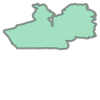

In [93]:
zones = gpd.read_file(r'../data/zonesv1.geojson')
hull = zones["geometry"].buffer(1e-3).unary_union
#geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull

## Road network

Build the road network graph from OpenStreetMap data and save it into GeoDataFrames

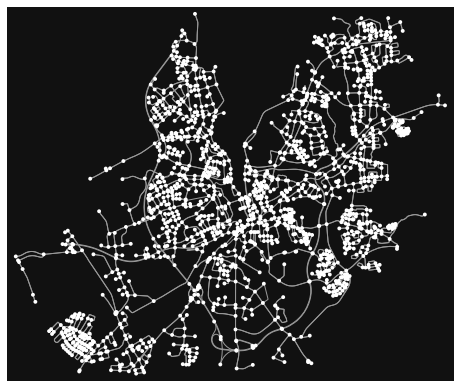

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [94]:
# Download roads from OpenStreetMap (online) and save it in a graph
# using the OSMNX library
drive = ox.graph_from_polygon(hull, network_type='drive')
# Plot it
ox.plot_graph(drive)

In [95]:
# Use OSMNX function to create GeoDataFrames from graph
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [96]:
road_nodes = road_nodes.reset_index()

In [97]:
# Let's have a look at the results
road_nodes.head(5)

,osmid,y,x,street_count,highway,geometry
0,26012989,54.761671,9.396664,3,NaN,POINT (9.39666 54.76167)
1,26012995,54.755484,9.402495,4,traffic_signals,POINT (9.40250 54.75548)
2,26013102,54.804837,9.423669,3,NaN,POINT (9.42367 54.80484)
3,26013139,54.805033,9.474248,4,traffic_signals,POINT (9.47425 54.80503)
4,26013154,54.806058,9.458361,3,NaN,POINT (9.45836 54.80606)


In [98]:
road_links = road_links.reset_index()

In [99]:
road_links.head(2)

,u,v,key,osmid,lanes,ref,name,highway,maxspeed,oneway,length,geometry,bridge,junction,width,access,tunnel
0,26012989,654163464,0,79258351,2,K 27,Ochsenweg,secondary,30,False,183.731,"LINESTRING (9.39666 54.76167, 9.39697 54.76126...",NaN,NaN,NaN,NaN,NaN
1,26012989,654163515,0,"[79263955, 51269724]",NaN,NaN,Hooger Weg,residential,30,False,275.879,"LINESTRING (9.39666 54.76167, 9.39708 54.76178...",NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

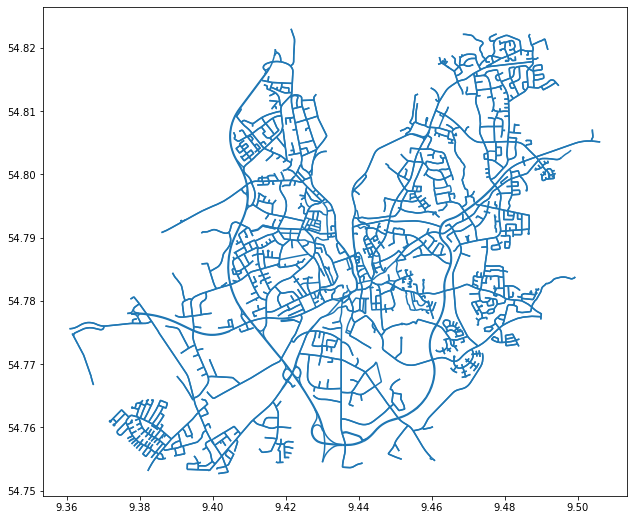

In [100]:
road_links.plot(figsize=(16,9))

In [101]:
# Check if the columns you want to use later are in the columns above.
# If they appear as index names (printed bold), use the reset_index()
# function to create a new Data
dataTypeSeries = road_nodes.dtypes
print(dataTypeSeries)


osmid              int64
y                float64
x                float64
street_count       int64
highway           object
geometry        geometry
dtype: object


In [102]:
# Rename columns and make them type string for later operations
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
#road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

In [103]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])
# Apply the function to all our links
road_links['geometry'] = road_links['geometry'].apply(simplify_link)

In [104]:
# Create a cleaner object and run cleaning functions on it
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [105]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
#oc.clean_geometries() # Doesn't work, but let's hope we don't need it
oc.fix_nodeset_consistency()

In [106]:
oc.__dict__.keys()

dict_keys(['links', 'nodes'])

Our road network is now saved in `oc.nodes` and `oc.links`

## Walk

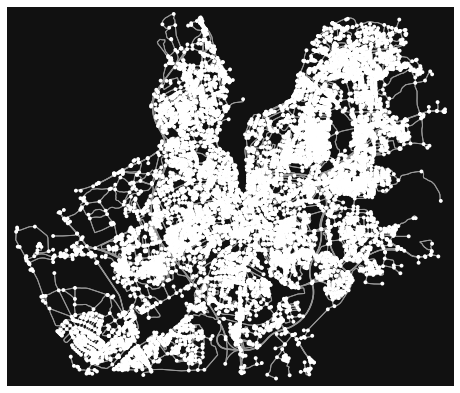

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [107]:
# Download roads from OpenStreetMap (online) and save it in a graph
# using the OSMNX library
walk = ox.graph_from_polygon(hull, network_type='walk')
# Plot it
ox.plot_graph(walk)

In [108]:
# Use OSMNX function to create GeoDataFrames from graph
footpath_nodes, footpath_links = ox.graph_to_gdfs(walk)

In [109]:
footpath_nodes = footpath_nodes.reset_index()

In [110]:
# Let's have a look at the results
footpath_nodes.head(5)

,osmid,y,x,street_count,highway,geometry
0,21929576,54.822503,9.468561,3,NaN,POINT (9.46856 54.82250)
1,26012979,54.774861,9.385369,4,NaN,POINT (9.38537 54.77486)
2,26012989,54.761671,9.396664,3,NaN,POINT (9.39666 54.76167)
3,26012995,54.755484,9.402495,4,traffic_signals,POINT (9.40250 54.75548)
4,26013099,54.807367,9.422835,3,NaN,POINT (9.42283 54.80737)


In [111]:
footpath_links = footpath_links.reset_index()

In [112]:
footpath_links.head(2)

,u,v,key,osmid,highway,oneway,length,geometry,service,lanes,ref,name,maxspeed,bridge,junction,access,width,tunnel
0,21929576,9077610843,0,981344824,path,False,6.139,"LINESTRING (9.46856 54.82250, 9.46864 54.82253)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21929576,1851263511,0,174437297,path,False,31.839,"LINESTRING (9.46856 54.82250, 9.46840 54.82257...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

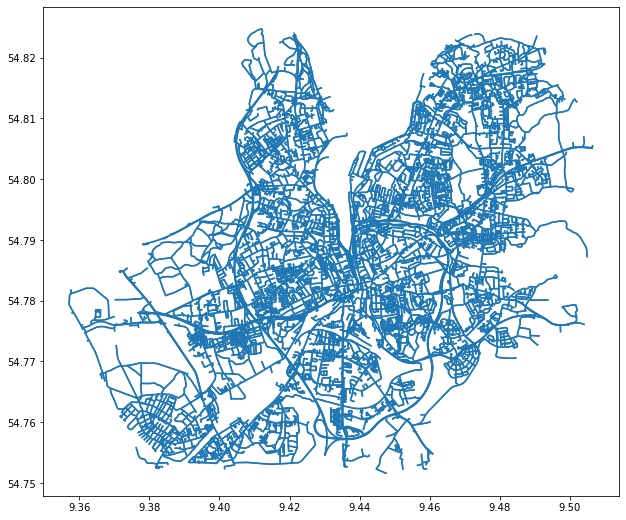

In [113]:
footpath_links.plot(figsize=(16,9))

In [114]:
# Check if the columns you want to use later are in the columns above.
# If they appear as index names (printed bold), use the reset_index()
# function to create a new Data
dataTypeSeries = footpath_nodes.dtypes
print(dataTypeSeries)
footpath_nodes.columns.values

osmid              int64
y                float64
x                float64
street_count       int64
highway           object
geometry        geometry
dtype: object


array(['osmid', 'y', 'x', 'street_count', 'highway', 'geometry'],
      dtype=object)

In [115]:
# Rename columns and make them type string for later operations
footpath_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
footpath_links[['from', 'to']] = footpath_links[['from', 'to']].astype(str)
footpath_nodes['osmid'] = footpath_nodes['osmid'].astype(str)
footpath_nodes = footpath_nodes.set_index('osmid')[['geometry']]
footpath_links[['from', 'to']] = footpath_links[['from', 'to']].astype(str)

In [116]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])
# Apply the function to all our links
footpath_links['geometry'] = footpath_links['geometry'].apply(simplify_link)

In [117]:
# Create a cleaner object and run cleaning functions on it
wk = OsmnxCleaner(
    footpath_links, 
    footpath_nodes, 
    a='from', 
    b='to'
)

In [118]:
wk.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
#wk.clean_geometries() # Doesn't work, but let's hope we don't need it
wk.fix_nodeset_consistency()

In [119]:
wk.__dict__.keys()

dict_keys(['links', 'nodes'])

The walk network is saved in wk.nodes and wk.links

## Cycling

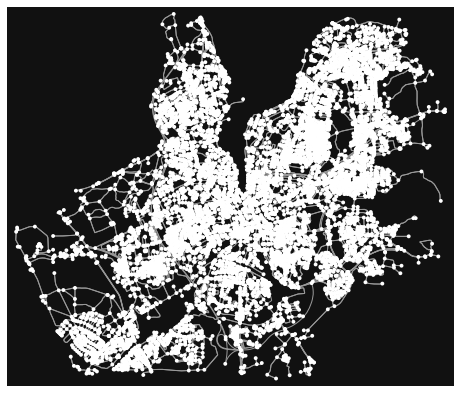

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [120]:
# Download roads from OpenStreetMap (online) and save it in a graph
# using the OSMNX library
cycling = ox.graph_from_polygon(hull, network_type='bike')
# Plot it
ox.plot_graph(cycling)

In [121]:
# Use OSMNX function to create GeoDataFrames from graph
bikelane_nodes, bikelane_links = ox.graph_to_gdfs(cycling)

In [122]:
bikelane_nodes = bikelane_nodes.reset_index()

In [123]:
# Let's have a look at the results
bikelane_nodes.head(5)

,osmid,y,x,street_count,highway,geometry
0,21929576,54.822503,9.468561,3,NaN,POINT (9.46856 54.82250)
1,26012979,54.774861,9.385369,4,NaN,POINT (9.38537 54.77486)
2,26012989,54.761671,9.396664,3,NaN,POINT (9.39666 54.76167)
3,26012995,54.755484,9.402495,4,traffic_signals,POINT (9.40250 54.75548)
4,26013099,54.807367,9.422835,3,NaN,POINT (9.42283 54.80737)


In [124]:
bikelane_links = bikelane_links.reset_index()

In [125]:
bikelane_links.head(2)

,u,v,key,osmid,highway,oneway,length,geometry,service,lanes,ref,name,maxspeed,bridge,junction,access,tunnel,width
0,21929576,9077610843,0,981344824,path,False,6.139,"LINESTRING (9.46856 54.82250, 9.46864 54.82253)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21929576,1851263511,0,174437297,path,False,31.839,"LINESTRING (9.46856 54.82250, 9.46840 54.82257...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

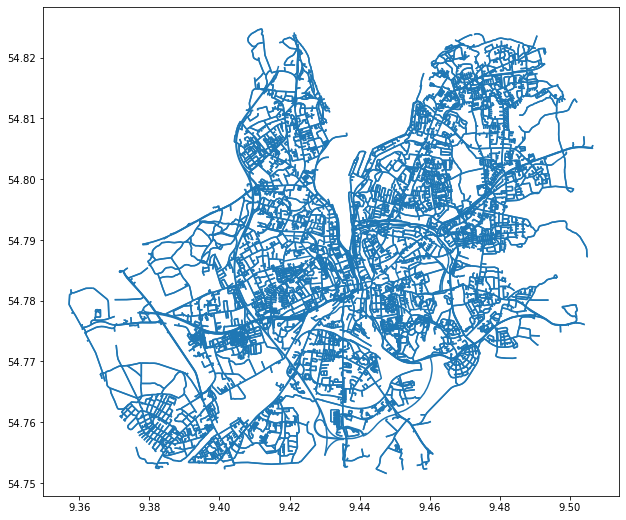

In [126]:
bikelane_links.plot(figsize=(16,9))

In [127]:
# Check if the columns you want to use later are in the columns above.
# If they appear as index names (printed bold), use the reset_index()
# function to create a new Data
dataTypeSeries = bikelane_nodes.dtypes
print(dataTypeSeries)
bikelane_nodes.columns.values

osmid              int64
y                float64
x                float64
street_count       int64
highway           object
geometry        geometry
dtype: object


array(['osmid', 'y', 'x', 'street_count', 'highway', 'geometry'],
      dtype=object)

In [128]:
# Rename columns and make them type string for later operations
bikelane_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
bikelane_links[['from', 'to']] = bikelane_links[['from', 'to']].astype(str)
bikelane_nodes['osmid'] = bikelane_nodes['osmid'].astype(str)
bikelane_nodes = bikelane_nodes.set_index('osmid')[['geometry']]
bikelane_links[['from', 'to']] = bikelane_links[['from', 'to']].astype(str)

In [129]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])
# Apply the function to all our links
bikelane_links['geometry'] = bikelane_links['geometry'].apply(simplify_link)

In [130]:
# Create a cleaner object and run cleaning functions on it
cy = OsmnxCleaner(
    bikelane_links, 
    bikelane_nodes, 
    a='from', 
    b='to'
)

In [131]:
cy.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
#cy.clean_geometries() # Doesn't work, but let's hope we don't need it
cy.fix_nodeset_consistency()

In [132]:
cy.__dict__.keys()

dict_keys(['links', 'nodes'])

The cycling network is saved in cy.nodes and cy.links

## Public Transport

For PT, we need to convert GTFS feeds into links and nodes GeoDataFrames

In [133]:
pwd


'/Users/codygelbrich/Desktop/nic/Term_Paper/codycode'

In [134]:
# Load the GTFS feed
full_feed = importer.GtfsImporter(path='/Users/codygelbrich/Desktop/nic/input_folder/dataJ', dist_units='m')

# downloaded from https://gtfs.de/de/feeds/

In [135]:
print (full_feed)

* agency --------------------
	  agency_id                     agency_name          agency_url  \
0         1                      HSB direkt  http://www.bahn.de   
1        10  Oberhavel Verkehrsgesellschaft  http://www.bahn.de   
2       100      Regionalbusverkehr Südwest  http://www.bahn.de   
3       101                      Schulligen  http://www.bahn.de   
4       102                 Spree-Neiße Bus  http://www.bahn.de   

  agency_timezone agency_lang  
0   Europe/Berlin          de  
1   Europe/Berlin          de  
2   Europe/Berlin          de  
3   Europe/Berlin          de  
4   Europe/Berlin          de  
* calendar --------------------
	   monday  tuesday  wednesday  thursday  friday  saturday  sunday start_date  \
0       0        0          0         0       0         1       1   20210710   
1       0        0          0         0       1         0       1   20210709   
2       0        0          0         0       1         1       0   20210709   
3       0        0   

In [136]:
#print (full_feed)
#full_feed = full_feed.reset_index()
#full_feed.head(5)
#full_feed.describe()

In [137]:
import janitor
#feed_r = df.filter_date(start_date,'20210903', '20210903')

In [138]:
full_feed.describe()

,indicator,value
0,agencies,"[HSB direkt, Oberhavel Verkehrsgesellschaft, R..."
1,running_services,"[142, 45, 51, 11, 130, 41, 122, 48, 66, 68, 11..."
2,timezone,Europe/Berlin
3,start_date,20210705
4,end_date,20210712
5,num_routes,20338
6,num_trips,1258805
7,num_stops,454908
8,num_shapes,0
9,num_frequencies,0


In [139]:
#full_feed.dtypes

In [140]:
# And we can restrict it spacially if we write a suitable function
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    #f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    #f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [141]:
full_feed.stops['parent_station'] = 0

# Doesn't work? Written by Cody 10.Aug

In [142]:
# Give the hourly restricted feed to the spatial restriction
feed_s = spatial_restrict(full_feed, polygon=hull, how='inner')
# Also was not working Cody - 10. Aug

In [143]:
# Restrict the feed to a given date in order to analyse a
# typical work day and not the whole week
feed_r = feed_s.restrict(
    dates=['20210706'] # the dates must be within the feed start and end dates
)
#df = df.rename(columns={'start_date': 'sdts'})
#feed_r = full_feed.start_date['20210830']

In [144]:
# We can also restrict it to hours
time_range = ['00:00:00', '24:00:00'] 
feed_r = feed_r.restrict(time_range=time_range)
# feed_t = full_feed

In [145]:
# GTFS feeds are very complex. Have a look at Wikipedia for its structure
# We neet to perform some operations in order to transform it into a graph
feed = feed_r.copy()
feed.group_services()
#feed.build_stop_clusters(distance_threshold=300) # clusterize stops
feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters
feed.trips['shape_id'] = 0

feed_frequencies = feed.convert_to_frequencies(time_range=time_range)

100%|█████████████████████████████████████████| 111/111 [00:01<00:00, 59.01it/s]


In [146]:
# We can build links and nodes now from the frequency graph
feed_frequencies.build_links_and_nodes()
feed_frequencies.build_geometries(use_utm=False)

export geometries in epsg: 32632


In [147]:
feed_frequencies.links.head(2)

,index,a,trip_id,link_sequence,departure_time,pickup_type,b,arrival_time,drop_off_type,time,...,pattern_id,route_id,service_id,direction_id,shape_id,route_long_name,route_short_name,agency_id,route_type,geometry
0,0,25368,10199_0,1,54420.0,NaN,89593,54480.0,NaN,60.0,...,10199_0,10199,59,0,0,840,840,70,3,"LINESTRING (9.50466 54.77597, 9.49043 54.77758)"
1,1,89593,10199_0,2,54480.0,NaN,344699,54540.0,NaN,60.0,...,10199_0,10199,59,0,0,840,840,70,3,"LINESTRING (9.49043 54.77758, 9.47831 54.77560)"


In [148]:
feed_frequencies.nodes.head(1)

,stop_name,stop_id,parent_station,geometry
3268,Adelby KTS/Kirche > Sünderup,451557,NaN,POINT (9.46589 54.78449)


In [149]:
# Make stop_id the unique index of nodes
# Use cluster_id if you built clusters before
feed_frequencies.nodes.set_index('stop_id', inplace=True)
len(feed_frequencies.nodes.loc[feed_frequencies.nodes.index.duplicated()])

0

In [150]:
# Rename the route types
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular', 8:'walk', 9:'cycling'}

#walking & cycling hinzugefügt

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

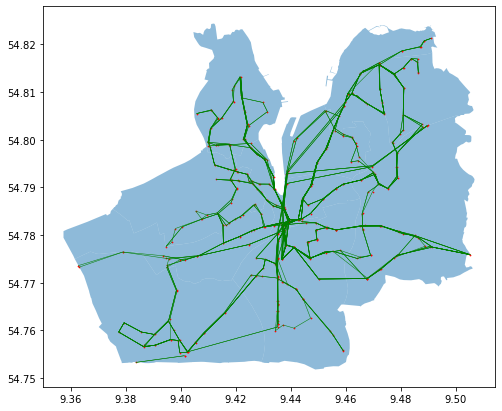

In [151]:
# Plot the results using matplotlib notation
ax = zones.plot(alpha=0.5, figsize=[17, 7])
ax = feed_frequencies.links.plot(linewidth=0.5, color='green', ax=ax)
plot= feed_frequencies.nodes.plot(markersize=0.5, color='red', ax=ax)

## Create the transport model

We have the network DataFrames and need to put them into a model now, to be able to run quetzal functions on it, that go beyond the scope of only one DataFrame

In [152]:
# Create the model with Coordinate Reference System 4326
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')

In [153]:
# Save zones into the model
sm.zones = zones

In [154]:
# Add road network
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway']]
sm.road_nodes = oc.nodes[['geometry']]

In [155]:
# Add walk network
sm.footpath_links = wk.links[['a', 'b', 'length', 'geometry', 'highway']]
sm.footpath_nodes = wk.nodes[['geometry']]

In [156]:
# Add cycling network
sm.bikelane_links = cy.links[['a', 'b', 'length', 'geometry', 'highway']]
sm.bikelane_nodes = cy.nodes[['geometry']]

In [157]:
sm.nodes

,geometry
node_0,POINT (0.00000 0.00000)


In [158]:
# Assign PT network to it with the columns we need
sm.links = feed_frequencies.links[['trip_id', 'a', 'b', 'link_sequence', 'time', 'headway',
                                   'pattern_id', 'route_id', 'service_id', 'direction_id',
                                   'agency_id', 'route_type', 'geometry']]
sm.nodes = feed_frequencies.nodes[['geometry', 'stop_name']]

In [159]:
sm.__dict__.keys()

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'footpath_links', 'footpath_nodes', 'bikelane_links', 'bikelane_nodes'])

## Check integrity

Run quetzals integrity check functions to see if the networks are alright

In [160]:
# check and fix name collision in the indicies
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


In [161]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 1806it [00:00, 6908.61it/s]
reversed: 1806it [00:00, 7408.58it/s]
1798it [00:00, 7153.86it/s]


In [162]:
# Fix PT
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()

dropped circular lines: ['9368_1', '9854_1', '16940_3']


In [163]:
# Test
sm.integrity_test_all(errors='raise')

1798it [00:00, 30465.83it/s]
0it [00:00, ?it/s]

passed: integrity_test_circular_lines
passed: integrity_test_collision
passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


1798it [00:00, 7097.66it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


## Cluster PT stops

Clustering has the advantage of reducing the model's file size and computational expenses. You can also leaf this step out.

In [164]:
len(sm.nodes)


465

In [165]:
# Clusterize nodes
sm.preparation_clusterize_nodes(n_clusters=300)
sm.nodes.head(1)

,geometry
cluster,
0,POINT (9.402304000000001 54.755432)


In [166]:
len(sm.nodes)

300

In [167]:
# Now, some links might go from one stop to the same
sm.links = sm.links.loc[sm.links['a']!=sm.links['b']]

In [168]:
# Fix network integrity again
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()

dropped circular lines: ['6731_0', '8996_0', '4648_3', '4648_2']
dropped broken sequences: []


In [169]:
# Check the integrity again
sm.integrity_test_all(errors='raise')

1798it [00:00, 30301.06it/s]
0it [00:00, ?it/s]

passed: integrity_test_circular_lines
passed: integrity_test_collision
passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


1798it [00:00, 6853.94it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


In [170]:
# Re-index nodes to prevent collision
sm.nodes.index = ['n_'+str(i) for i in sm.nodes.index]
sm.links['a'] = 'n_' + sm.links['a'].astype(str)
sm.links['b'] = 'n_' + sm.links['b'].astype(str)

In [171]:
sm.links.sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,geometry,disaggregated_a,disaggregated_b
index,,,,,,,,,,,,,,,
link_1494,906_0,n_134,n_276,13,60.0,2009,906_0,906,59,0,136,bus,"LINESTRING (9.42412 54.79272, 9.42050 54.79324)",node_45492,node_26285


## Network connectors

We have road and PT links and nodes. Now we need to connect them for people to be able to switch and enter as they want

In [172]:
# Create a footpaths table
sm.preparation_footpaths(max_length=1000, n_clusters=300)
sm.footpaths.head(3)

,a,b,geometry,length,voronoi,time
footpath_0,n_158,n_159,"LINESTRING (9.379364000000001 54.7616, 9.38565...",457.394879,1,548.873855
footpath_1,n_158,n_39,"LINESTRING (9.379364000000001 54.7616, 9.37741...",249.693308,1,299.631970
footpath_2,n_39,n_117,"LINESTRING (9.377419 54.759655, 9.383637 54.75...",813.436287,1,976.123545


In [173]:
len(sm.footpaths)

1574

In [174]:
# Delete all of the footpaths that go across the water 

sm.footpaths.drop(sm.footpaths.loc[sm.footpaths['time']==1110.0331338844169].index, inplace=True)
sm.footpaths.drop(sm.footpaths.loc[sm.footpaths['time']==1096.5406144017347].index, inplace=True)
sm.footpaths.drop(sm.footpaths.loc[sm.footpaths['time']==912.844442979798].index, inplace=True)
sm.footpaths.drop(sm.footpaths.loc[sm.footpaths['time']==654.2086964810331].index, inplace=True)
sm.footpaths.drop(sm.footpaths.loc[sm.footpaths['time']==433.95351677964976].index, inplace=True)
sm.footpaths.drop(sm.footpaths.loc[sm.footpaths['time']==370.50192260169615].index, inplace=True)
sm.footpaths.drop(sm.footpaths.loc[sm.footpaths['time']==413.5736123552411].index, inplace=True)
sm.footpaths.drop(sm.footpaths.loc[sm.footpaths['time']==374.8650130028865].index, inplace=True)
sm.footpaths.drop(sm.footpaths.loc[sm.footpaths['time']==379.98199635957195].index, inplace=True)

In [175]:
len(sm.footpaths)

1556

In [176]:
# Create access and egress links (ntlegs)
threshold = 200
sm.preparation_ntlegs(
    short_leg_speed=3, # km/h
    long_leg_speed=7, # km/h
    threshold=threshold, # m
    zone_to_transit=True, # zone centroid - PT connectors
    zone_to_road=True, # zone centroid - road connectors
    n_ntlegs=5 # number of connectors
)

In [177]:
# This is how the new tables look like
# Re-index them too
sm.zone_to_transit.index = ['ztt_'+str(i) for i in sm.zone_to_transit.index]
sm.zone_to_transit.sample(1)

,a,b,rank,distance,geometry,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time,walk_time
ztt_63,n_146,zone_8,0,515.239091,LINESTRING (9.486527146431856 54.8094016121831...,eggress,1.605053,3,7,4.815159,385.212744,385.212744


In [178]:
sm.zone_to_road.index = ['ztr_'+str(i) for i in sm.zone_to_road.index]
sm.zone_to_road.sample(1)

,a,b,rank,distance,geometry,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time,walk_time
ztr_40,zone_7,1817875389,3,421.824363,LINESTRING (9.444548000932302 54.7687494357688...,access,1.452282,3,7,4.356845,348.547582,348.547582


In [179]:
sm.road_to_transit.index = ['rtt_'+str(i) for i in sm.road_to_transit.index]
sm.road_to_transit.sample(1)

,a,b,rank,distance,geometry,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time,walk_time
rtt_2071,385294334,n_250,1,39.6308,"LINESTRING (9.4719535 54.816046, 9.471413 54.8...",eggress,0.445145,3,7,3.0,47.55696,47.55696


## Save the model

We have a complete network with connectors. Now save it.

quetzal provides two functions. One is the to_zip (and read_zip for loading again), which is very fast, but the file format is hdf5, which is not compatible with other programs.

The other option is to_json (and read_json), which saves tables as GeoJSON format. This is great to look at them in GIS software like QGIS, but it is slower for larger models.

Both functions take the location string as a first argument and optionally the only_attributes argument, where you can pass a list of table names that should be saved. All others are discarded.

In [180]:
sm.to_json('../../model/network')

to_hdf(overwriting):  64%|██████████████▏       | 27/42 [00:01<00:01, 14.85it/s]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes
could not save geometry from table mode_nests
could not save geometry from table logit_scales
could not save geometry from table utility_values


to_hdf(overwriting): 100%|██████████████████████| 42/42 [00:10<00:00,  3.96it/s]

could not save attribute: missing_road_nodes
could not save attribute: missing_nodes
could not save attribute: orphan_nodes
